# COGS 108 - State Infrastructure Spending in Relation to Accidents

Final Video link: https://youtu.be/yNZVuGZQX5Q

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ `X` ] YES - make available
* [  ] NO - keep private

# Overview

This project explores the relationship between state to state funding of road infastructure and its impact on accidents per capita. We narrowed our analysis to the Unites States and only analysed data from 2016-2020. We collected data from online sources and performed linear regression to analyze this data. From our R-squared value, we see that there is a very weak correlation between spending and accidents, including when accounting for accidents per capita as a potential confounding variable. Therefore, there are likely other explanations for differences in accidents from state to state, which were not included in our data set. 

# Names

- Adan Estrada
- Alexandre Marques
- Angel Mencia
- Brian Nhieu

# Research Question

Is there a relationship between the funding of major city's road infastructure and the amount of car accidents per capita in the United States from the years 2016 to 2020?

## Background & Prior Work

### Introduction: 

While on the road, there are many different factors that can affect how an accident occurs. For example, driving while intoxicated, speeding, poor vehicle maintainence, or even road conditions. According to roadsafetyfacts.eu, '90% of all road accidents are linked to human error'. In which case, states are able to directly affect how road conditions are maintained, thus clearing confusions that could occur while driving. According to roadsafetyfacts.eu, 'unclear traffic signs, poor lane markings, poor road surfaces, and bad road design can be dangerous'. Thus, we can take a closer look at what our road maintiners can do, inorder to provide better road surfaces, better resources, and a proactive government can do to the amount of accidents that occur in that state.

Narrowing our scope to specifically the United States, it is important to note just how poor the road conditions are in a country like the United States. According to FVF Law, in 2017, the American Society of Civil Engineers determined that the United States were ranked D+ in the country's infrastructure. Specifically, bridges were graded C+, while roads were graded D. Compared to the entire world, the United States went from ranked 5th in the world in 2013, to ranked 10th in 2016, according to the The World Economic Forum.

Sources:
1. https://roadsafetyfacts.eu/what-role-do-road-users-and-infrastructure-play-in-improving-safety/
2. http://jhtransport.gov.in/causes-of-road-accidents.html
3. https://www.fvflawfirm.com/america-aging-infastructure/


### Prior Work:

In a study done by M. Rojo, H. Gonzalo-Orden, A. Linares, and L. dell'Olio, they focused on the effects of the economic recession and how Spain's conservative infrastructure bill affected accidents/road safety between 2008 - 2017. It was noted that the infrastructure budget decreased by 66% and road maintenance decreased by 21% from 2008 to 2017. The researchers were able to conclude that throughout the years, the number of fatalities from accidents has decreased/leveled out since 2013 due to the advances of newer technologies in vehicles. However, it was also noted that the decrease in budget led to a higher cost of accidents, between 0.7 and 2.2 times more frequent.

Source: https://www.hindawi.com/journals/jat/2018/9570465/


# Hypothesis

We predict that more spending towards road construction will lessen the rate of which accidents occur. 

We believe that this will occur because of how important it is for drivers to have tools to prevent accidents, such as routine checks for potholes, or upkeep on road lighting.

# Dataset(s)

- US Accidents (updated)
  - https://www.kaggle.com/sobhanmoosavi/us-accidents
  - 1516064
  - Contains a broad range of traffic accidents that happened in 49 states of the USA from February 2016 to December 2020. Each accident is its own entry including lots of additional information about the accident, so we'll have to tally them all up by state and drop the additional information.
- State Population Totals: 2010-2020
  - https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/totals/nst-est2020-alldata.csv
  - 57
  - Contains population data from the 2010 census and estimates for 2011-2020, including changes in population, deaths and births. Each entry represents each area, which can be a state or a more general area, and all the different years are in different collumns resulting in a small dataset.
- State and Local Government Transportation Revenues and Expenditures
  - https://www.bts.gov/browse-statistical-products-and-data/state-transportation-statistics/state-and-local-government
  - 37341
  - Contains the investment or revenue in different types of infrastructure for each source per state for each year between 2010 and 2020. Our interest is only in the highways investment, and we'll take a look at the total investment without regard of where the money came from.
- State Transportation Infrastructure
  - https://www.bts.gov/state-transportation-infrastructure
  - 202
  - Contains the miles of road, railroad, waterway, and bridges per state for each year between 2010 and 2020. Each entry contains the information for the specific state and measure for all the years. Our interest is only in the "Miles of public road".

To combine the datasets, all datasets will be formated to have a key of State and Year, with the state being the abrevation, and then we'll merge the datasets.

# Setup

In [1]:
# same as D5
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 104)
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
# initial datasets read
df_acc = pd.read_csv("data/US_accidents.csv")
#accidents = pd.read_pickle("data/processed_acc.pkl") # get processed pickle of df_acc
df_pop= pd.read_csv("data/US_population.csv")
df_infra = pd.read_csv("data/US_infrastructure.csv")

The next dataset was only available as a crosstable or excel file. I choose the excel file.
However, for easier import I edited it a bit. I removed the first line, that only had "Year", so that the column names were correct, and unmerged all the states in such a way that the merged cells all have the same text.

In [3]:
# !pip install --user openpyxl # might be needed
df_roads = pd.read_excel("data/US_road.xlsx")

# Data Cleaning

#### US Accidents (updated)
The US Accidents dataset gave a record of every accident they could gather in the United States. The record included specific ID's and additional information, like temperature and weather. The first thing to do was to drop unneccesary columns, though some of them were kept so that we can check for potential confounding variables. The Start_Time column included a string denoting down to the second when the accident happended, however, this had to be converted to an integer to denote the yaer it happened in. Finally, the data had to be compiled by state and year for it to be comparable with the other datasets. The resulting dataset was saved as a pickle, because the original dataset was to large for github.

In [4]:
# get only useful info about crash
df_acc.drop(columns=list(df_acc.columns[3:15]) + list(df_acc.columns[16:21]) + list(df_acc.columns[29:43]) + list(df_acc.columns[44:]) + ["ID", "Wind_Direction"], inplace=True)
# change start time from string to year int
df_acc["Start_Time"] = pd.to_numeric(df_acc["Start_Time"].str.slice(0,4))   
df_acc.rename(columns={"Start_Time":"Year"}, inplace=True)
# assign Night a value of 1 and Day 0
df_acc.Sunrise_Sunset = np.where(df_acc.Sunrise_Sunset == "Night", 1, 0)
# make df grouped by year and state
accidents = df_acc.groupby('Year')['State'].value_counts().reset_index(name='Accidents')
# add additional info for future checking
accidents = pd.merge(accidents, df_acc.groupby(["Year", "State"])["Severity"].mean().reset_index(name='Severity'), on=['State', 'Year'])
for col in df_acc.columns[3:]:
    accidents = pd.merge(accidents, df_acc.groupby(["Year", "State"])[col].mean().reset_index(name=col), on=['State', 'Year'])
# save pickle as accidents is to large
accidents.to_pickle("data/processed_acc.pkl")
accidents.head()

,Year,State,Accidents,Severity,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Sunrise_Sunset
0,2016,CA,34464,2.180449,68.076180,54.814100,56.726686,29.956342,9.413236,8.726897,0.028212,0.227397
1,2016,FL,10292,2.303342,79.397247,74.577444,70.672882,30.057711,9.576064,8.927113,0.055752,0.232899
2,2016,TX,9614,2.453505,75.402390,44.665722,66.538634,30.027981,9.544653,8.681853,0.060443,0.291970
3,2016,IL,7741,2.457693,58.667370,19.054604,68.704207,30.062971,9.247530,9.633881,0.035423,0.271024
4,2016,NY,6941,2.481343,62.607889,29.887361,60.551211,30.022800,9.419075,9.835863,0.216383,0.246218


#### State Population Totals: 2010-2020
The state population was organized by state and had many columns for the years, however we wanted the dataset to be organized by state and year. On top of this there were many useless columns denoting change in population and specific details that were ignored. We had to sweep the dataset and create a new one from scratch to have state and year as the key, also the state was fully written which we preferred it to be abreviated.

In [5]:
# select only the state and population, no change or deaths or other info
df_pop = df_pop.iloc[:,3:18]
# renaming collumns for better use  -> probably not going to be needed
#renaming = {}
#for old_name in df_pop.columns:
#    if "POPESTIMATE20" in old_name:
#        renaming[old_name] = old_name[-4:]  # just the year number
#df_pop.rename(columns=renaming, inplace=True)

# make df grouped by year and state
state_abrv = {"Alabama": "AL","Alaska":"AK","Arizona":"AZ","Arkansas":"AR","California":"CA", "Canal Zone":"CZ","Colorado":"CO","Connecticut":"CT", "Delaware":"DE", "District of Columbia":"DC","Florida":"FL","Georgia":"GA","Guam":"GU","Hawaii":"HI","Idaho":"ID","Illinois":"IL","Indiana":"IN","Iowa":"IA","Kansas":"KS","Kentucky":"KY","Louisiana":"LA", "Maine":"ME","Maryland":"MD","Massachusetts":"MA","Michigan":"MI","Minnesota":"MN","Mississippi":"MS","Missouri":"MO","Montana":"MT","Nebraska":"NE","Nevada":"NV","New Hampshire": "NH","New Jersey":"NJ", "New Mexico":"NM","New York":"NY", "North Carolina":"NC","North Dakota":"ND","Ohio":"OH","Oklahoma":"OK","Oregon":"OR","Pennsylvania":"PA","Puerto Rico":"PR","Rhode Island":"RI","South Carolina":"SC","South Dakota":"SD","Tennessee":"TN","Texas":"TX","Utah":"UT","Vermont":"VT","Virgin Islands":"VI","Virginia":"VA","Washington":"WA","West Virginia":"WV","Wisconsin":"WI","Wyoming":"WY", "United States":"USA", 'Northeast Region':"NER", 'Midwest Region':"MWR",'South Region':"SOR", 'West Region':"WER"}
pop = []
for name in range(0,df_pop.shape[0]):
    for year in range(2010,2021):
        pop.append([state_abrv[df_pop.iloc[name,1]], int(year), df_pop.iloc[name,year-2006]])
population = pd.DataFrame(pop)
population.rename(columns={0:"State", 1:"Year", 2:"Population"}, inplace=True)
population.head()

,State,Year,Population
0,USA,2010,309327143
1,USA,2011,311583481
2,USA,2012,313877662
3,USA,2013,316059947
4,USA,2014,318386329


#### State and Local Government Transportation Revenues and Expenditures
The revenues and expenditures had a lot of entries with diverse uses. However, we are only interested in expenditure on highways, so had to filter out all of the rest. Also, the spending was broken down by source, so we opted to take the total spending from both state and local sources. After that, all that needed to be done was create a new dataset with the key we wanted. The states also had to be abreviated in this dataset.

In [6]:
# drop useless columns
df_infra.drop(columns=["Detail", "Note", "Updated", "Number of Records"], inplace=True)
# select only spending for highways 
df_infra = df_infra[df_infra["Type"] == "Expenditure"]
df_infra = df_infra[df_infra["Mode"] == "Highway"]
df_infra = df_infra[df_infra["Government"] == "State and Local"]
df_infra.drop(columns=["Type", "Mode", "Government"], inplace=True)
# get total spending by Year and State 
spending = pd.DataFrame(df_infra.groupby(["Year", "State"])["Amount (thousands)"].sum().reset_index(name='Amount (thousands)'))
for i in range(0, spending.shape[0]):
    spending.State.iloc[i] = state_abrv[spending.State.iloc[i]]
spending.head()

,Year,State,Amount (thousands)
0,2004,AL,2610892
1,2004,AK,1363897
2,2004,AZ,3290471
3,2004,AR,2066918
4,2004,CA,16654699


#### State Transportation Infrastructure
The state infrastructure included many kinds of infrastructure, out of which we were only interested in roads, so we filtered for that data. 

In [7]:
df_roads = df_roads[df_roads["Measure"] == "Miles of public road"]
r = []
for name in range(0,df_roads.shape[0]):
    for year in range(2010,2021):
        r.append([state_abrv[df_roads.iloc[name,0]], int(year), df_roads.iloc[name,year-2008]])
roads = pd.DataFrame(r)
roads.rename(columns={0:"State", 1:"Year", 2:"Roads"}, inplace=True)
roads.head()

,State,Year,Roads
0,USA,2010,4083767.858
1,USA,2011,4094446.992
2,USA,2012,4109420.689
3,USA,2013,4132152.964
4,USA,2014,4194257.078


#### Merging
As all the sets have been shaped to have the same key, merging is a very simple task. Unfortunately, we could not find a dataset with state expenditures that included 2020, so quite some data is lost. Another piece of data that is completely lost is the state of Puerto Rico.

In [8]:
# merge all datasets into one
a_by_p = pd.merge(accidents.iloc[:,:3], population, on=['State', 'Year'])
s_by_r = pd.merge(spending, roads, on=['State', 'Year'])
final = pd.merge(a_by_p, s_by_r, on=['State', 'Year'])
final.head()

,Year,State,Accidents,Population,Amount (thousands),Roads
0,2016,CA,34464,39149186,24101100,180799.99
1,2016,FL,10292,20627237,17589483,122735.79
2,2016,TX,9614,27914064,22699436,313656.12
3,2016,IL,7741,12821709,16024132,145892.44
4,2016,NY,6941,19636391,18743678,113499.35


We can check for any specific loss of data by checking if there is an entry for every state in every year. If there is a loss, those entries will be printed out.

In [9]:
# check is there is any entry that is missing
to_find = []
missing = []
for i in range(final.Year.unique().shape[0]):
    for j in range(final.State.unique().shape[0]):
        to_find.append([final.Year.unique()[i], final.State.unique()[j]])
found = final.iloc[:,0:2].values.tolist()
for i in range(len(to_find)):
    if not to_find[i] in found:
        missing.append(to_find[i])
missing

[[2017, 'ND']]

We can see that the final dataset is clean. This is because, the intermediate datasets are mostly clean and merging them makes it such that these unclean entries are dropped.

In [10]:
final.isnull().sum()

Year                  0
State                 0
Accidents             0
Population            0
Amount (thousands)    0
Roads                 0
dtype: int64

The most problematic dataset is the dataset relating to the accidents. Fortunately the missing data is not the most important, such that the data calculated in the final dataset is all clean. However, most of the variables that could be used to analyse confounding have many missing entries, so the analysis at the end will have some limits.

In [11]:
df_acc.isnull().sum()

Severity                  0
Year                      0
State                     0
Temperature(F)        43033
Wind_Chill(F)        449316
Humidity(%)           45509
Pressure(in)          36274
Visibility(mi)        44211
Wind_Speed(mph)      128862
Precipitation(in)    510549
Sunrise_Sunset            0
dtype: int64

# Data Analysis & Results

Firstly, it is important to take a look at the total number of accidents in each individual state. Here, we are taking a look at the top 15 states with the largest number of accidents. The different graphs allow us to see the trend between these top 15 states and the years. From 2016-2019, we can see that California is consistently getting into more accidents compared to other states. (There is a large gap in 2019 - Outlier). With these graphs, we can also see states like Florida starting at the top 2, and slowly dropping down to the 5th spot in 2019

Text(0.5, 1.0, 'Top 15 in 2019')

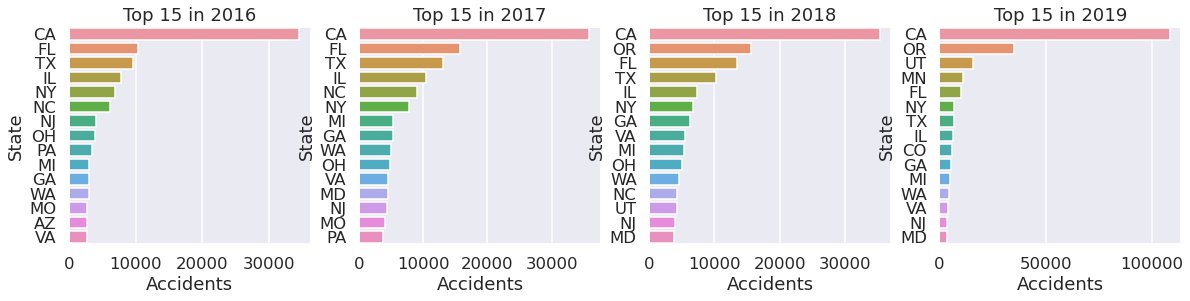

In [12]:
acc_in_2016 = final[(final['Year'] == 2016)][:15]
acc_in_2017 = final[(final['Year'] == 2017)][:15]
acc_in_2018 = final[(final['Year'] == 2018)][:15]
acc_in_2019 = final[(final['Year'] == 2019)][:15]
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols = 4, sharey = False)
plt.subplots_adjust(right = 2.7)
sns.barplot(y='State', x='Accidents', data=acc_in_2016, ax=ax1)
ax1.set_title('Top 15 in 2016')
sns.barplot(y='State', x='Accidents', data=acc_in_2017, ax=ax2)
ax2.set_title('Top 15 in 2017')
sns.barplot(y='State', x='Accidents', data=acc_in_2018, ax=ax3)
ax3.set_title('Top 15 in 2018')
sns.barplot(y='State', x='Accidents', data=acc_in_2019, ax=ax4)
ax4.set_title('Top 15 in 2019')

Following the same idea as above, we want to take a look at how the top 15 states are setting their budgets. Here we can see how California's infrastructure budget relates to its competitors in the top 15. In the first 2 years, California and Texas were leaders in which states had the largest budget. However, as the years continued, Texas shot past. Potentially leading to their descent from the top 15? Interestingly, we see that a state like Oregan went from the bottom 15 in accidents to 2nd place in 2018-2019, with a tiny budget.

Text(0.5, 1.0, 'Budgets for Top 15 in 2019')

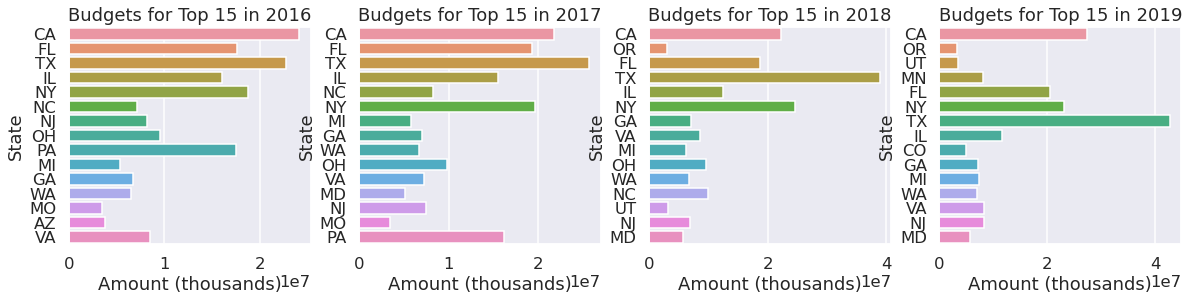

In [13]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols = 4, sharey = False)
plt.subplots_adjust(right = 2.7)
sns.barplot(y='State', x='Amount (thousands)', data=acc_in_2016, ax=ax1)
ax1.set_title('Budgets for Top 15 in 2016')
sns.barplot(y='State', x='Amount (thousands)', data=acc_in_2017, ax=ax2)
ax2.set_title('Budgets for Top 15 in 2017')
sns.barplot(y='State', x='Amount (thousands)', data=acc_in_2018, ax=ax3)
ax3.set_title('Budgets for Top 15 in 2018')
sns.barplot(y='State', x='Amount (thousands)', data=acc_in_2019, ax=ax4)
ax4.set_title('Budgets for Top 15 in 2019')

Lastly, it is important to visualize the change in accidents, budgets, and population throughout the years. Throughout the 4 years, we can see that accidents and the budget has been slowly increasing, with a large outlier in 2019 for California. However, population has remain relatively constant. Interestingly, this goes aganist our hypothesis since we thought the pandemic would have affects on the number of accidents and the total amount of budget allocated per state.

Text(0.5, 1.0, 'Total Population between 2016-2019')

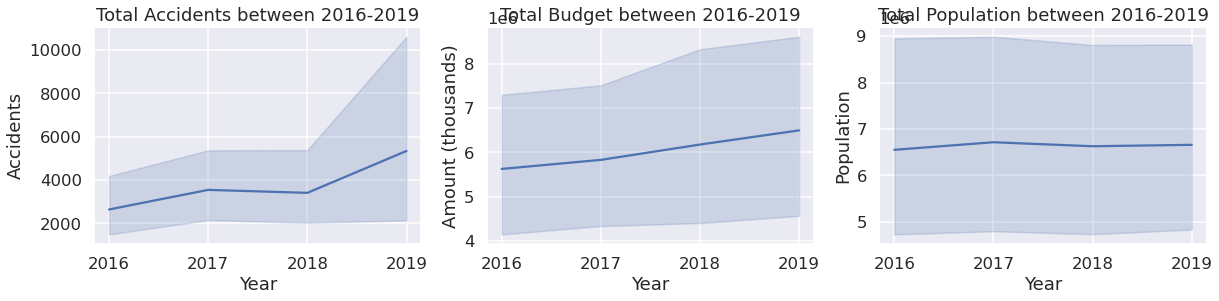

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 3, sharey = False)
plt.subplots_adjust(right = 2.7)
sns.lineplot(x = 'Year', y = 'Accidents', data=final, ax=ax1)
ax1.set_title('Total Accidents between 2016-2019')
sns.lineplot(x = 'Year', y = 'Amount (thousands)', data=final, ax=ax2)
ax2.set_title('Total Budget between 2016-2019')
sns.lineplot(x = 'Year', y = 'Population', data=final, ax=ax3)
ax3.set_title('Total Population between 2016-2019')

Text(0.5, 1.0, 'Relationship between number of accidents and state budget')

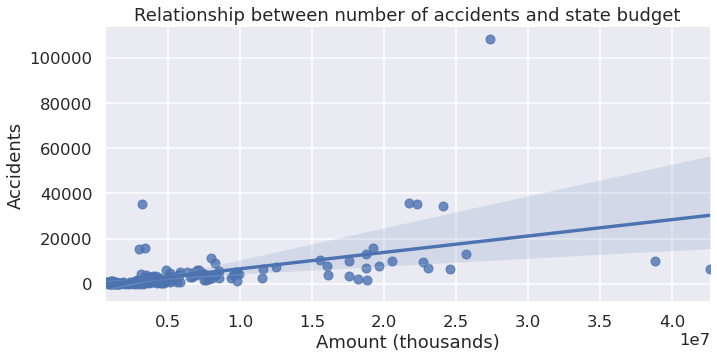

In [15]:
sns.lmplot(x='Amount (thousands)', y='Accidents', data=final, aspect=2)
plt.title('Relationship between number of accidents and state budget')

From the plot above, there is a very poor correlation between the budget for infrastructure compared to the amount of accidents in America. Interestingly, we can see that as we increase the budget, there is a slight increase in the number of accidents. This is a poor correlation comparison to why the budget can affect the number of accidents. This is because we are not taking into account the number of people per state. Let's take a look at the top 15 states with the most accidents.

Text(0.5, 1.0, 'Population for Top 15 in 2019')

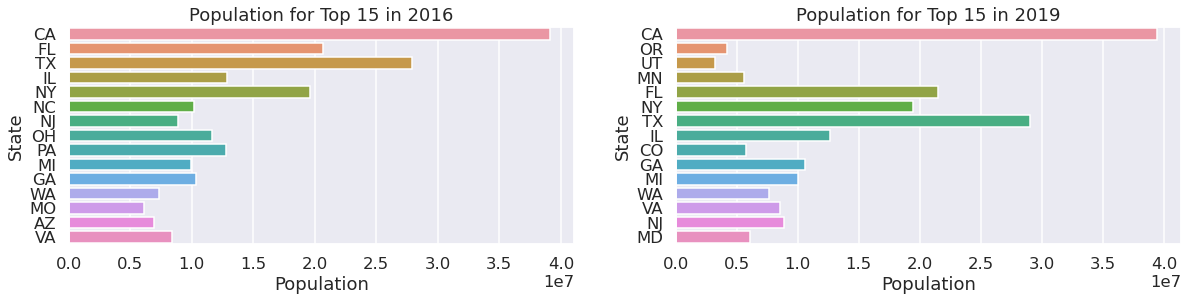

In [16]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, sharey = False)
plt.subplots_adjust(right = 2.7)
sns.barplot(y='State', x='Population', data=acc_in_2016, ax=ax1)
ax1.set_title('Population for Top 15 in 2016')
sns.barplot(y='State', x='Population', data=acc_in_2019, ax=ax2)
ax2.set_title('Population for Top 15 in 2019')

In this plot, we can see that California and Texas have a much larger population density compared to other states. This makes it difficult for us to confidently produce a correlation between budget and accidents, since some states will have a larger population, resulting in a larger budget, but also resulting in a larger amounts of accidents. More cars implies there will likely be more accidents.

In [17]:
new = final.rename(columns={'Amount (thousands)' : 'Amount'})
outcome_1, predictors_1 = patsy.dmatrices('Accidents ~ Amount', new)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:              Accidents   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     70.31
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           1.05e-14
Time:                        17:35:06   Log-Likelihood:                -2029.6
No. Observations:                 195   AIC:                             4063.
Df Residuals:                     193   BIC:                             4070.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -649.9689    778.630     -0.835      0.4

In this regression model, we can see that the variance explained is quite low. It says that the budget in which a state contributes/allows explains only 26.7%% of all accidents within this time period. Which is VERY low. This means that the correlation between the two can NOT be concluded. We can see that this is true by looking at the line of regression in the graph above. There is a larger spread of values from then line.

What about when we account for population?

In [18]:
outcome_2, predictors_2 = patsy.dmatrices('Accidents ~ Amount + Population', new)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:              Accidents   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     111.6
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           7.04e-33
Time:                        17:35:06   Log-Likelihood:                -1984.7
No. Observations:                 195   AIC:                             3975.
Df Residuals:                     192   BIC:                             3985.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1640.9228    627.098     -2.617      0.0

Well in this regression model, we can see that there is a better R-squared, but it is not very strong. Here, we can say that the budgets provided by states, and the number of population explains 53.8% of accidents in the United States between 2016 - 2020.


The only dataset that has not been looked at is the dataset containing the information of the roads. The amount of roads likely plays a part in accidents, because depending on how many miles of road a state has a certain budget can create differing amounts of road qualoty and safety. Here we can see how the amount of roads vary between the top 15 states in accidents, which should help indicate how spread out the budget may be.

Text(0.5, 1.0, 'Road miles for Top 15 in 2019')

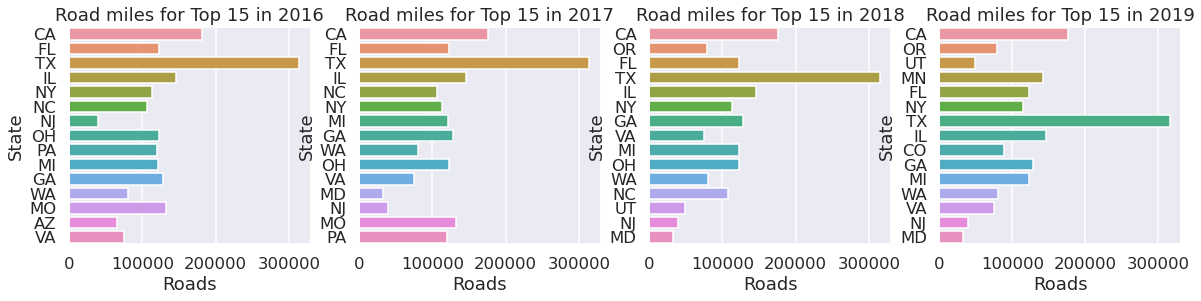

In [19]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols = 4, sharey = False)
plt.subplots_adjust(right = 2.7)
sns.barplot(y='State', x='Roads', data=acc_in_2016, ax=ax1)
ax1.set_title('Road miles for Top 15 in 2016')
sns.barplot(y='State', x='Roads', data=acc_in_2017, ax=ax2)
ax2.set_title('Road miles for Top 15 in 2017')
sns.barplot(y='State', x='Roads', data=acc_in_2018, ax=ax3)
ax3.set_title('Road miles for Top 15 in 2018')
sns.barplot(y='State', x='Roads', data=acc_in_2019, ax=ax4)
ax4.set_title('Road miles for Top 15 in 2019')

From looking at this representation of road miles, we can see that the graph shape is similar to the population graph.
This concludes the representation of the datasets.

After looking at the data separately, we should try to see if there are more complicated relationships in the data.
The first relationship we'll analyse is accidents per capita, because as mentioned above more cars likely implies more accidents. This would be important in analysing the data, because if we simply take the number of accidents we would likely end up relating them to population and not the amount of money spent on infrastructure.

Text(0.5, 1.0, 'Top 15 in 2019')

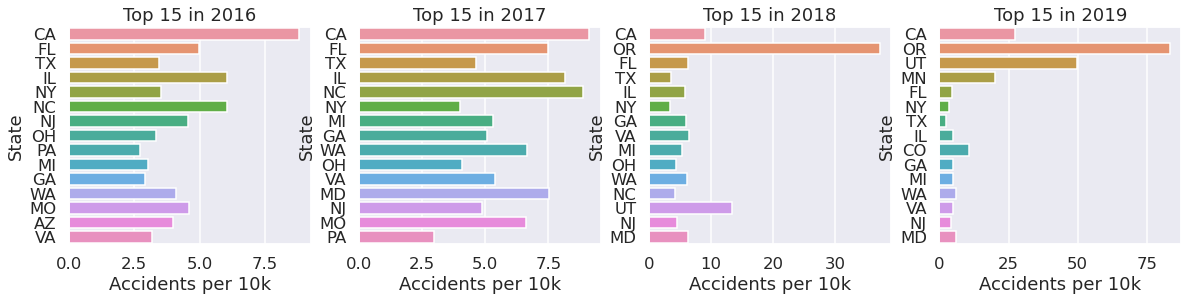

In [20]:
acc_in_2016["Accidents per 10k"] = acc_in_2016["Accidents"] / acc_in_2016["Population"] * 10000
acc_in_2017["Accidents per 10k"] = acc_in_2017["Accidents"] / acc_in_2017["Population"] * 10000
acc_in_2018["Accidents per 10k"] = acc_in_2018["Accidents"] / acc_in_2018["Population"] * 10000
acc_in_2019["Accidents per 10k"] = acc_in_2019["Accidents"] / acc_in_2019["Population"] * 10000
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols = 4, sharey = False)
plt.subplots_adjust(right = 2.7)
sns.barplot(y='State', x='Accidents per 10k', data=acc_in_2016, ax=ax1)
ax1.set_title('Top 15 in 2016')
sns.barplot(y='State', x='Accidents per 10k', data=acc_in_2017, ax=ax2)
ax2.set_title('Top 15 in 2017')
sns.barplot(y='State', x='Accidents per 10k', data=acc_in_2018, ax=ax3)
ax3.set_title('Top 15 in 2018')
sns.barplot(y='State', x='Accidents per 10k', data=acc_in_2019, ax=ax4)
ax4.set_title('Top 15 in 2019')

Here we can see that for the first 2 years all results look close together and increasing over time, but in the last 2 years Oregon is an outlier with a massive increase. On top of that, during the last year California, Utah, and Minnesota also increase significantly.
Now we see that there are some outliers in accidents per capita, perhaps they are related to the amount of money spent on infrastructure.
For similar reasons as above, measuring only the absolute data does not make much sense, as the spending may be spread thin on a large amount of road.
For this spending per mile must be determined.

Text(0.5, 1.0, 'Top 15 in 2019')

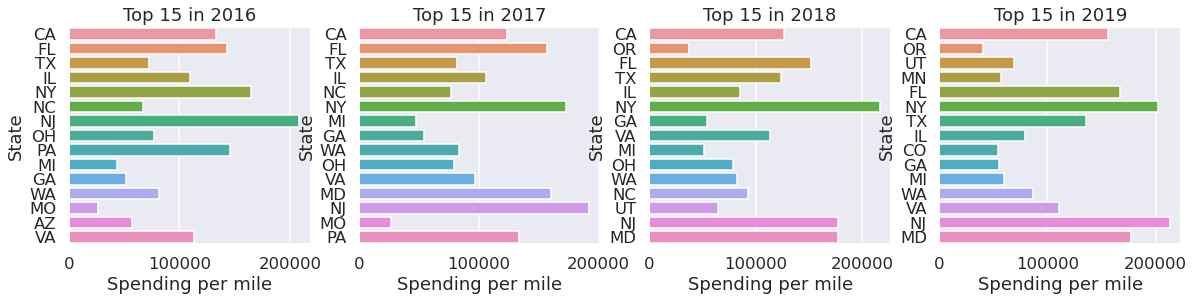

In [21]:
acc_in_2016["Spending per mile"] = acc_in_2016["Amount (thousands)"] / acc_in_2016["Roads"] * 1000
acc_in_2017["Spending per mile"] = acc_in_2017["Amount (thousands)"] / acc_in_2017["Roads"] * 1000
acc_in_2018["Spending per mile"] = acc_in_2018["Amount (thousands)"] / acc_in_2018["Roads"] * 1000
acc_in_2019["Spending per mile"] = acc_in_2019["Amount (thousands)"] / acc_in_2019["Roads"] * 1000
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols = 4, sharey = False)
plt.subplots_adjust(right = 2.7)
sns.barplot(y='State', x='Spending per mile', data=acc_in_2016, ax=ax1)
ax1.set_title('Top 15 in 2016')
sns.barplot(y='State', x='Spending per mile', data=acc_in_2017, ax=ax2)
ax2.set_title('Top 15 in 2017')
sns.barplot(y='State', x='Spending per mile', data=acc_in_2018, ax=ax3)
ax3.set_title('Top 15 in 2018')
sns.barplot(y='State', x='Spending per mile', data=acc_in_2019, ax=ax4)
ax4.set_title('Top 15 in 2019')

From looking at these top 15 values the hypothesis may be correct, as the massive outliers of Utah and Oregon have low spending per mile.
However, California would tell a different story, being the 3th in accidents per capita and the 5th in spending per mile.
As this is a small snapshot of the data, a closer look at the relationship between both rates would be appropriate. 

Text(0.5, 1.0, 'Relationship between accidents per capita and state budget per mile')

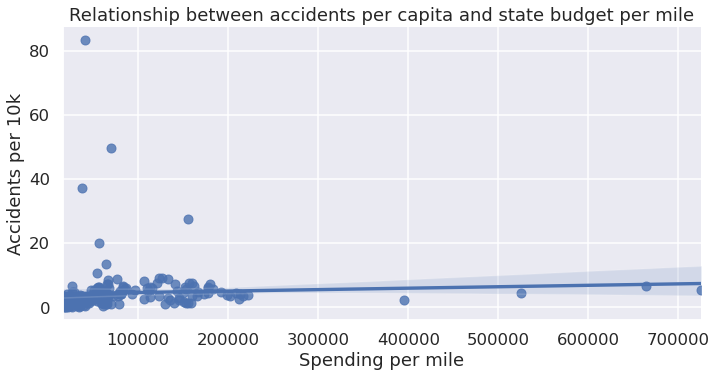

In [22]:
final["Accidents per 10k"] = final["Accidents"] / final["Population"] * 10000
final["Spending per mile"] = final["Amount (thousands)"] / final["Roads"] * 1000

sns.lmplot(x='Spending per mile', y='Accidents per 10k', data=final, aspect=2)
plt.title('Relationship between accidents per capita and state budget per mile')

In [23]:
new = final.rename(columns={'Spending per mile' : 'Spending', 'Accidents per 10k' : 'Accidents_per_capita'})
outcome_1, predictors_1 = patsy.dmatrices('Accidents_per_capita ~ Spending', new)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                             OLS Regression Results                             
Dep. Variable:     Accidents_per_capita   R-squared:                       0.003
Model:                              OLS   Adj. R-squared:                 -0.002
Method:                   Least Squares   F-statistic:                    0.5396
Date:                  Mon, 14 Mar 2022   Prob (F-statistic):              0.463
Time:                          17:35:09   Log-Likelihood:                -672.31
No. Observations:                   195   AIC:                             1349.
Df Residuals:                       193   BIC:                             1355.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1036      0.754

The last potential confounding variables that we are able to analyse are the weather conditions gathered from the accidents dataset. When looking at this data it is important to note that as mentioned in the data wrangling there were multiple data entries for different weather conditions missing. This will make any interpretation of the data seen below weaker. On top of this, the data that is going to be displayed has already been averaged on and each entry represents an entire year in a state. This makes detailed analysis harder as the data isn't as precise as it could be. On top of this, some measures of the weather may not be directly related, as for example if temperature has a positive correlation, it could just be that more people drive during warmer weather as going out while extremely cold is not enjoyable. 

To visualize the data, I'll be using a scatter matrix of the accidents dataframe, but in this case I'm only interested in two rows: year and accidents. The accidents is obvious as I'm trying to see if any of the weather conditions. I kept the year row in as the weather might show some patterns of change due to climate change, which could end up explaining the increase in accidents per capita over the years.

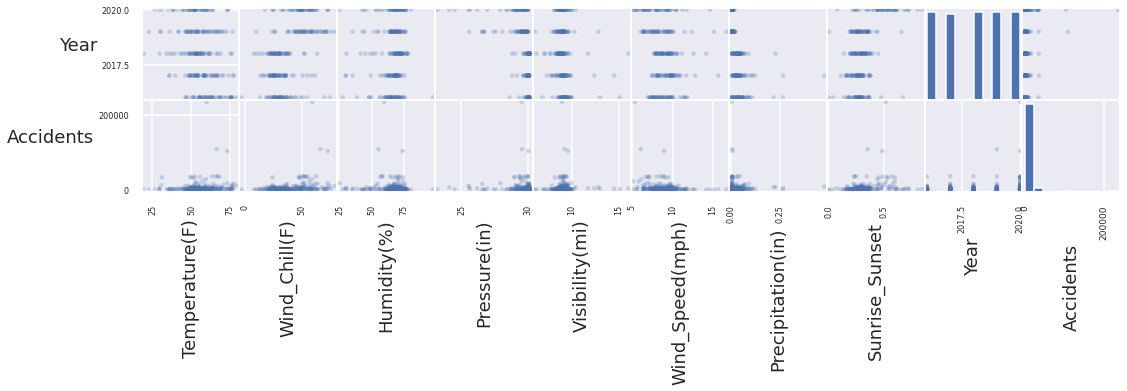

In [24]:
acc_reorder = accidents
acc_reorder = acc_reorder[list(acc_reorder.columns[4:]) + list(acc_reorder.columns[:3])]

axes = pd.plotting.scatter_matrix(acc_reorder, alpha=0.25, figsize=(16,16))

for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        if i < 8:
            axes[i,j].set_visible(False)
            
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.show()

Upon observation of the accidents row, no weather property appears to have a significant relationship with accidents. All of the scatterplots have most of the data close to the x axis and the best fit line would be pratically horizontal with a low R squared, just like our previous relationships between accidents and infrastructure spending.

# Ethics & Privacy

Despite the data for the accidents being collected from well-respected sources, such as US and State Department, law enforcement agencies and traffic cameras, there is a bias that allows for a more concise result from larger states, such as California, Texas and Florida. This is due to the data collected in the set, where California can have ~971,000 entries, while a smaller state like Wyoming will only have 520. Another issue that arises with these datasets is the lack of knowledge in what states' budget directly affect the square feet of roads that they must maintain. For example, California's data could be difficult to compare to Rhode Island. 

Lastly, the dataset that we are considering goes into the beginning of Covid-19 and does not consider the effects of social distancing and quarantine requirements per state. A more progressive state could potentially have less drivers on the road compared to others, due to different state lockdown requirements.

Regarding data privacy, we are omitting the specific location at which these accidents occur. For example, we do not need the exact locations, rather just the anonymous submission of the state.

# Conclusion & Discussion

In conclusion, we can see that despite accounting for accidents per capita as a confounding variable, there was still very little correlation between spending and accidents per state. This confounding variable could however have been dealt with better. As not everyone owns and drives a car, using a dataset including the number of car owners would have yielded better results for analysis. However, we could not find such a dataset.


While spending on roads is important, there are certainly many others reasons contributing to accidents. Unfortunately, different contributing factors, such as weather (snowy states, high rain density, etc), are hard to quantify. When we tried to use scatter plots to help visualize the effects different weather conditions might have on accidents, we see that we receive nearly horizontal lines in each plot, implying low R^2 values and thus little correlation between weather and accidents. Surprisingly enough, we expected to see a stronger correlation factor when accounting for accidents per capita, as we would expect more cars to imply more accidents. However, there was still very little correlation between spending and accidents keeping this in mind.


Additionally, we noticed that some states, such as Oregon, follow our expected trend very well. We can see a drop off in spending from 2017 to 2018, and in turn accidents rose nearly to the top of the list. While the cause of this lack of funding is unknown, it could suggest that infastructure funding does in fact have some sort of influence on accidents.

# Team Contributions

- Mix of everyone:
  - Research Question
  - Hypothesis
  - Ethics and Privacy
- Adan Estrada
  - Overview
  - Conclusion & Discussion
  - Proof reading
- Alexandre Marques
  - Datasets
  - Setup
  - Data Cleaning
  - EDA of roads dataset and after
- Angel Mencia
- Brian Nhieu
  - EDA until roads dataset
  - Background and Prior Work
  - Video edits
